In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# mpl.rcParams['figure.figsize'] = (6,6)
# mpl.rcParams['figure.dpi'] = 100
# mpl.rcParams["image.origin"] = 'lower'

In [49]:
config = {
    "base_dir":        "/eos/home-d/dmapelli/public/latino/",
    "plot_config":     "Full2018v6s5",
    "cut":             "res_sig_mjjincl",
    "model_version":   "v17",
    "model_tag":       "res_3depth_v2",
    "samples_version": "v10",
    "cols": ['mjj_vbs', 'vbs_0_pt', 'vbs_1_pt', 'deltaeta_vbs', 'deltaphi_vbs', 
             'mjj_vjet', 'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 
             'Lepton_pt', 'Lepton_eta', 
             'PuppiMET', 
            ]
}

In [50]:
len(config["cols"])

13

```.python
"cut":             "boos_sig_mjjincl",
"cut":             "res_sig_mjjincl",

"model_tag":       "res_5depth_v0",

    "cols": ['mjj_vbs', 'deltaeta_vbs', 
            'mjj_vjet', 
            'Lepton_pt', 'Lepton_eta' ]
    "cols": ['mjj_vbs', 'vbs_0_pt', 'vbs_1_pt', 'deltaeta_vbs', 'deltaphi_vbs', 
          'mjj_vjet', 'vjet_0_pt', 'vjet_1_pt', 'vjet_0_eta', 'vjet_1_eta', 
         'Lepton_pt', 'Lepton_eta', 'Lepton_flavour', 
         'PuppiMET', 
         'Zvjets_0', 'Zlep', 
         'Asym_vbs', 'Asym_vjet', 'A_ww', 
         'Mtw_lep', 'w_lep_pt', 'Mww', 'R_ww', 'R_mw', 
         'Centr_vbs', 'Centr_ww'
         ]
 ```

In [51]:
import os

config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

## Samples preparation for NN

In [52]:
## using 
## source /cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/setup.sh
#!pip3 install --user imbalanced-learn==0.5

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split

from imblearn.keras import balanced_batch_generator
from imblearn.over_sampling import RandomOverSampler

import tensorflow
    
import keras
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Model, Sequential
from keras.layers import Dense,Activation, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Deconvolution2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from keras import backend as K
from keras.callbacks import *

Using TensorFlow backend.


In [7]:
## instead of reading the variables from file,
## we now set the variables here, and then dump them
# import yaml
# yaml_vars = yaml.safe_load(open(os.path.join(model_dir, "variables.yml")))
# print("yaml: ", type(yaml_vars), len(yaml_vars))
# cols = yaml_vars

In [53]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values

In [54]:
X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])

In [55]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pickle.dump(scaler, open(f"{model_dir}/scaler_model.pkl", "wb"))

In [56]:
# i = 2
# print(cols[i])
# fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5), dpi=100)
# ax1.hist(X[:,i], bins=50)
# ax1.set_yscale("log")
# ax2.hist(X_scaled[:,i], weights=W, bins=50)
# plt.yscale("log")

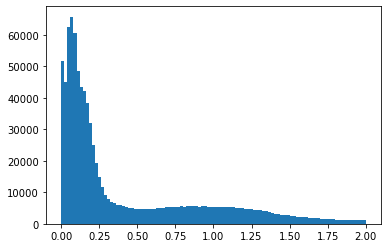

In [57]:
# _ = plt.hist(W, bins=100)
_ = plt.hist(W, bins=100, range=(0,2))

##  Balancing


In [58]:
config["test_size"] = 0.2
config["val_size"]  = 0.5  ## test != val
# config["val_size"]  = 0.0  ## test == val

X_train, X_temp, y_train, y_temp, W_train, W_temp = train_test_split(X_scaled, Y,      W,      test_size=config["test_size"])
X_val,   X_test, y_val,   y_test, W_val,   W_test = train_test_split(X_temp,   y_temp, W_temp, test_size=config["val_size"]) ## test != val

In [59]:
print("Training   dataset: ", X_train.shape)
print("Test + Val dataset: ", X_temp.shape)
print("Testing    dataset: ", X_test.shape)
print("Validation dataset: ", X_val.shape)

Training   dataset:  (847011, 13)
Test + Val dataset:  (211753, 13)
Testing    dataset:  (105877, 13)
Validation dataset:  (105876, 13)


Create generators to balance signal and background

In [60]:
config["batch_size"] = 256

training_generator,   steps_per_epoch_train = balanced_batch_generator(X_train, y_train, W_train, batch_size=config["batch_size"], sampler=RandomOverSampler())
validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_val,   y_val,   W_val,   batch_size=config["batch_size"], sampler=RandomOverSampler()) ## test != val
#validation_generator, steps_per_epoch_val   = balanced_batch_generator(X_temp,  y_temp,  W_temp,   batch_size=config["batch_size"], sampler=RandomOverSampler()) ## test == val

## Keras model

In [33]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
%autoreload 2

In [62]:
# import local module that programmatically returns keras models
import models

model = models.get_model(config["model_tag"], X_train.shape[1])

model.summary()

>>> Creating model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 50)                700       
_________________________________________________________________
batch_normalization_7 (Batch (None, 50)                200       
_________________________________________________________________
activation_7 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               5100      
_________________________________________________________________
batch_normalization_8 (Batch (None, 100)               400       
_________________________________________________________________
activation_8 (Activation)    (None, 100)              

In [63]:
## import and configure the plot loss callback

import plot_loss

data = {
    "X_train": X_train,
    "X_test" : X_test, ## test != val
    #"X_test" : X_temp, ## test == val
    "y_train": y_train,
    "y_test" : y_test, ## test != val
    #"y_test" : y_temp, ## test == val
    "W_train": W_train,
    "W_test" : W_test, ## test != val
    #"W_test": W_temp, ## test == val
}

plot_losses = plot_loss.PlotLosses(model, data)

KS test (dnn output: true train vs true temp) Ks_2sampResult(statistic=0.017460364886457802, pvalue=0.0008877074622885752) . good:  False


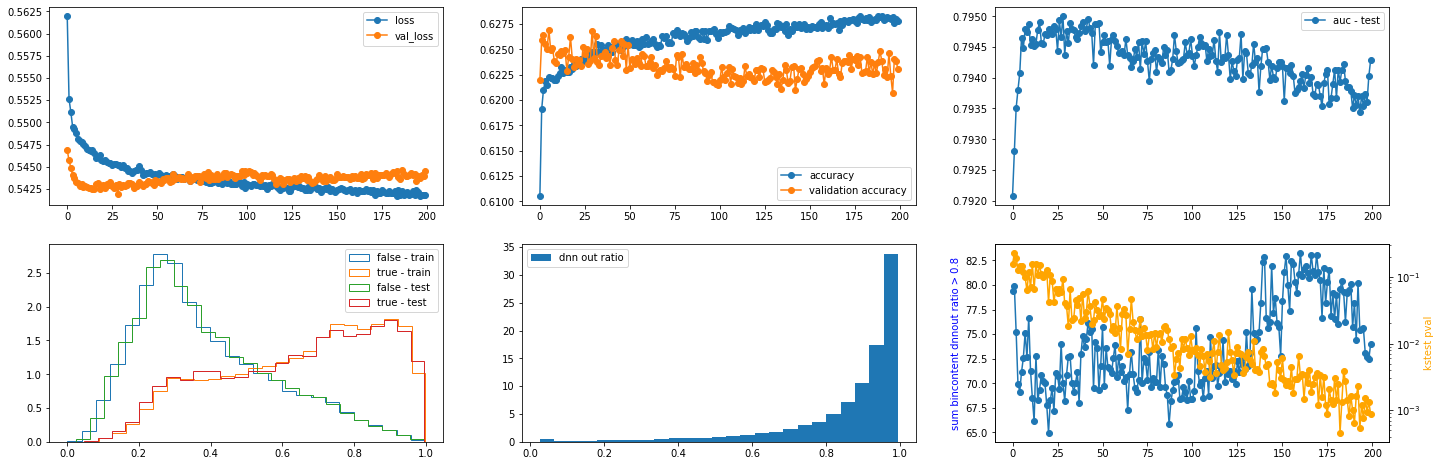

In [64]:
import time
start_time = time.time()

config["epochs"] = 200

history = model.fit_generator(
            training_generator, 
            epochs=config["epochs"],
            steps_per_epoch  = steps_per_epoch_train, 
            validation_data  = validation_generator, 
            validation_steps = steps_per_epoch_val,
            callbacks=[plot_losses],
            #callbacks = [], 
            )

config["train_time"] = time.time() - start_time

In [65]:
## SAVE THE MODEL, ITS METADATA AND TRAINING INFORMATIONS

# dump the variables list
import yaml
varfile = os.path.join(model_dir, "variables.yml")
if os.path.isfile(varfile):
    print("ACHTUNG! variables file already existing: old file renamed with '_old'")
    os.rename(varfile, varfile[:-4] + "_old.yml")
with open(varfile, "w") as out_var_file:
    out_var_file.write(yaml.dump(config["cols"]))
    
# dump the config
config["a__model_dir"] = model_dir
model_config_file = os.path.join(model_dir, "model_config.yml")
if os.path.isfile(model_config_file):
    print("ACHTUNG! model_config_file file already existing: old file renamed with '_old'")
    os.rename(model_config_file, model_config_file[:-4] + "_old.yml")
with open(model_config_file, "w") as out_var_file:
    out_var_file.write(yaml.dump(config))  

# save figure with training summary
plot_losses.save_figure( os.path.join(model_dir, "model_train.png") )

# save keras model
model.save( os.path.join(model_dir, "model.h5") )

In [1]:
## Retrieve graphs history
## plot 
# n = 30
# plt.hist(plot_losses.dnn_score_plot[n][0][1][:-1], bins=plot_losses.dnn_score_plot[n][0][1], weights=plot_losses.dnn_score_plot[n][0][0], histtype="step")
# plt.hist(plot_losses.dnn_score_plot[n][1][1][:-1], bins=plot_losses.dnn_score_plot[n][1][1], weights=plot_losses.dnn_score_plot[n][1][0], histtype="step")

# Evaluation

>>> Computing AUC...


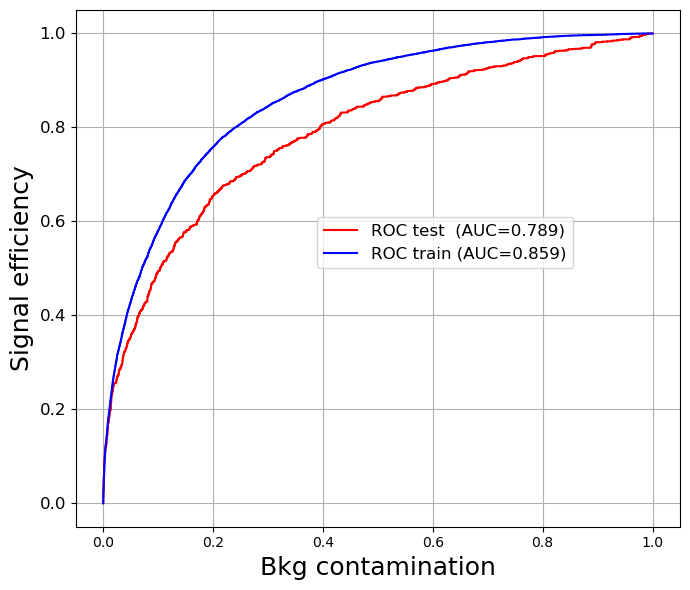

In [106]:
# Evalutation
print(">>> Computing AUC...")

from sklearn.metrics import roc_auc_score, roc_curve

pred_test  = model.predict(X_test,  batch_size=2048)
pred_train = model.predict(X_train, batch_size=2048)
auc_w_test  = roc_auc_score(y_test, pred_test,  sample_weight=W_test)
auc_w_train = roc_auc_score(y_train,pred_train, sample_weight=W_train)
fpW_test,  tpW_test,  thW_test  = roc_curve(y_test,  pred_test , sample_weight=W_test)
fpW_train, tpW_train, thW_train = roc_curve(y_train, pred_train, sample_weight=W_train)
#print("AUC score: " + str(auc))

fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

# ax1.plot(fp, tp, label=f"ROC (AUC={auc:.3f})", color="blue")
ax1.plot(fpW_test,  tpW_test,  label=f"ROC test  (AUC={auc_w_test:.3f})", color="red")
ax1.plot(fpW_train, tpW_train, label=f"ROC train (AUC={auc_w_train:.3f})", color="blue")

ax1.set_xlabel("Bkg contamination", fontsize=18)
ax1.set_ylabel("Signal efficiency", fontsize=18)

#ax1.plot([0,1],[1,1],"b--")
ax1.tick_params("y",labelsize="large")

ax1.grid()

ax1.legend(loc=(0.4, 0.5), fontsize="large")

fig.tight_layout()

In [107]:
#r = model.evaluate_generator(training_generator, steps=1000)
#r = model.evaluate_generator(validation_generator, steps=1000)


In [108]:
#print(model.metrics_names, r)

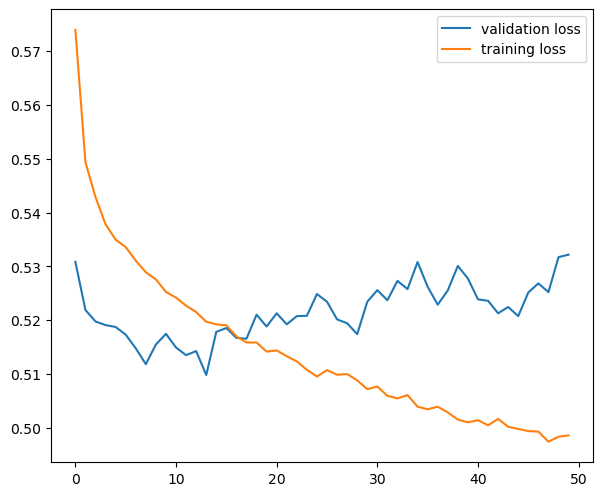

In [109]:
fig, ax = plt.subplots(figsize=(7,6), dpi=100)
ax.plot(history.epoch, history.history["val_loss"], label="validation loss")
ax.plot(history.epoch, history.history["loss"], label="training loss")
plt.legend()

Ks_2sampResult(statistic=0.05555648480868425, pvalue=9.592003820461245e-05)

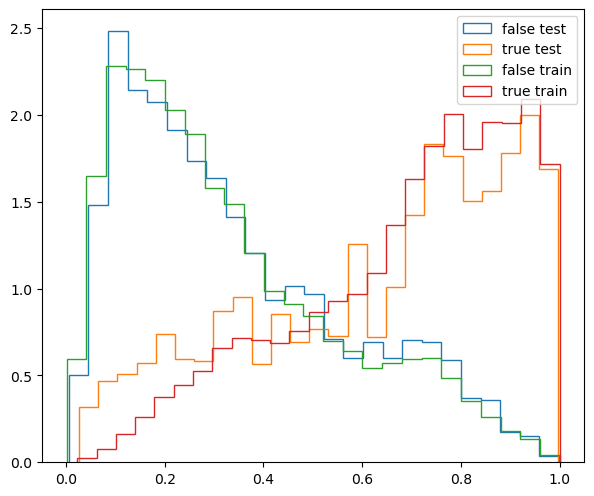

In [110]:
results_test  = model.predict(X_test, batch_size=2048)
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(results_test[y_test==0],weights=W_test[y_test==0], bins=25, density=True, label="false test", histtype="step")
plt.hist(results_test[y_test==1],weights=W_test[y_test==1], bins=25, density=True, label="true test", histtype="step")
results_train = model.predict(X_train, batch_size=2048)
plt.hist(results_train[y_train==0],weights=W_train[y_train==0], bins=25, density=True, label="false train", histtype="step")
plt.hist(results_train[y_train==1],weights=W_train[y_train==1], bins=25, density=True, label="true train", histtype="step")
#plt.yscale("log")
plt.legend()

# 
# 

#results_train[y_train==1]
rtest  = [x[0] for x in results_test[y_test==1]]
rtrain = [x[0] for x in results_train[y_train==1]]

from scipy import stats
stats.ks_2samp(rtrain, rtest)

## Evaluation by sample

In [57]:
bkg["y"] = model.predict(scaler.transform(bkg[config["cols"]].values), batch_size=2048)

In [58]:
signal["y"] = model.predict(scaler.transform(signal[config["cols"]].values), batch_size=2048)

In [59]:
wjets = bkg[bkg["sample_name"] == "Wjets"]
top = bkg[bkg["sample_name"] == "top"]
dy = bkg[bkg["sample_name"] == "DY"]

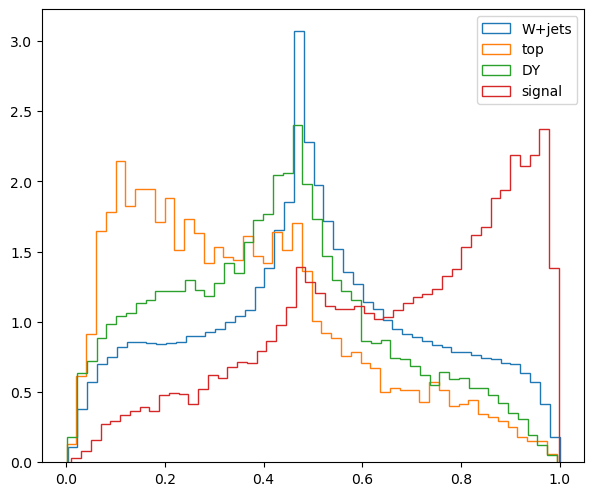

In [60]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(bkg[bkg["sample_name"] == "Wjets"]["y"], bins=50, density=True, label="W+jets", histtype="step")
plt.hist(bkg[bkg["sample_name"] == "top"]["y"],   bins=50, density=True, label="top",    histtype="step")
plt.hist(bkg[bkg["sample_name"] == "DY"]["y"],    bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()

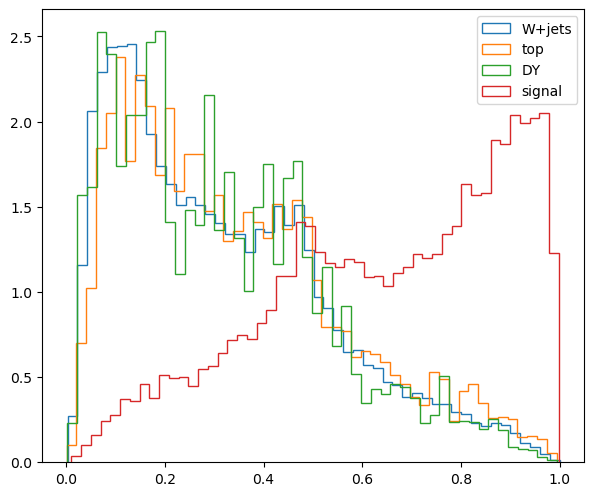

In [112]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(wjets["y"], weights=wjets.weight_norm, bins=50, density=True, label="W+jets", histtype="step")
plt.hist(top["y"],   weights=top.weight_norm,  bins=50, density=True, label="top",    histtype="step")
plt.hist(dy["y"],    weights=dy.weight_norm,  bins=50, density=True, label="DY",     histtype="step")

plt.hist(signal["y"], weights=signal.weight_norm, bins=50,density=True, label="signal", histtype="step")
#plt.yscale("log")
plt.legend()

In [ ]:
## some useful snippets

## callbacks
# auto_save = ModelCheckpoint("../models/model12_balanced_100_50.hd5", monitor='val_loss', 
#                     verbose=1, save_best_only=True, save_weights_only=False, 
#                     mode='auto', period=5)
#
# early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, 
#                             patience=10, verbose=1)






## In case you do not want to use the generators
# history = model.fit(
#             X_train,y_train, 
#             sample_weight=W_train, 
#             epochs=50,
#             validation_data = (X_val, y_val, W_val),
#             batch_size=1024,
#             shuffle=True 
#             )